In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import scale

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

import seaborn as sns 

from xgboost.sklearn import XGBRegressor
import xgboost as xgb

import math
%config InlineBackend.figure_format='retina'

In [2]:
#read in the retail price dataset and clean it for consistent format
residential_price=pd.read_csv("residential_price.csv")

climate = pd.read_csv('Climate_regression.csv')
electricity = pd.read_csv('residential-cleaned-Jul9.csv')
solar = pd.read_csv('residential-distributed-solar-encoded.csv')
popu = pd.read_csv('Cleaned-Population_by-month-by-state_0714.csv')
energy_source = pd.read_csv('integration_final.csv')

In [3]:
#First-Stage-Merge
combine = residential_price.merge(climate,how = 'inner', left_on = ['Year','Month','State'], right_on = ['year','month','state'])
combine = combine.merge(electricity, how = 'inner',on = ['Year','Month','State'])
combine = combine.merge(energy_source, how = 'inner', left_on = ['Year','Month','State'], right_on = ['YEAR','MONTH','STATE'])

In [4]:
#dataframe without solar
combine_1 = combine.merge(popu,how = 'inner',on = ['Year','Month','AK', 'AL', 'AR', 'AZ', 'CA', 'CO',
       'CT', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY',
       'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD',
       'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'])

#dataframe with solar
combine_2 = combine_1.merge(solar,how = 'left',on = ['year','month','AK', 'AL', 'AR', 'AZ', 'CA', 'CO',
       'CT', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY',
       'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD',
       'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'])

In [5]:
#Clean redundant and unnecessary columns
combine_1  =  combine_1.drop(['State', 'year', 'month', 'state','YEAR','MONTH', 'STATE',
                              'Megawatthours','mkwh','DC', 'US', 'Country'],axis = 1)
combine_2 = combine_2.drop(['State', 'year', 'month', 'state','YEAR','MONTH', 'STATE',
                            'DC_x','DC_y','US','Country', 'Megawatthours','mkwh', ], axis = 1)

combine_2 = combine_2.dropna()


In [6]:
#Create Dummy Season Variable
def CreateSeasonDummy(df):
    df['Season'] = df.Month.map({12:'Winter',1:'Winter',2:'Winter',3:'Spring',4:'Spring',5:'Spring',6:'Summer',7:'Summer',8:'Summer',9:'Fall',10:'Fall',11:'Fall'})
    df = pd.get_dummies(df,columns = ['Season'])
    return df
    
combine_1 = CreateSeasonDummy(combine_1)
combine_2 = CreateSeasonDummy(combine_2)

In [7]:
#Create a dataframe for regression analysis
us_residential_data = combine_2.drop(['Year', 'Month', 'Year_Month', 'Coal', 'Geothermal',
       'Hydroelectric Conventional', 'Natural Gas', 'Nuclear', 'Other',
       'Other Biomass', 'Other Gases', 'Petroleum', 'Pumped Storage',
       'Solar Thermal and Photovoltaic', 'Total', 'Wind',
       'Wood and Wood Derived Fuels','PA','Season_Spring'], axis=1)

## Multicolinearity Test  

In [8]:
us_residential_data.columns

Index(['Cents/kWh', 'CLDD', 'TAVG', 'AWND', 'HTDD', 'area', 'AK', 'AL', 'AR',
       'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN',
       'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC',
       'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'RI', 'SC',
       'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY',
       'residential_usage', 'Population', 'solar-generation', 'Season_Fall',
       'Season_Summer', 'Season_Winter'],
      dtype='object')

In [9]:
#multicolinearity test
def cal_vif(df,columns):
    features= df[columns]
    X = add_constant(features)
    vif=pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)    
    return vif

columns = ['Cents/kWh', 'CLDD', 'TAVG', 'AWND', 'HTDD', 'area', 'Population', 'solar-generation']

print(cal_vif(us_residential_data,columns))

print()
print("-------------After removing TAVG--------------")
print()

us_residential_data.drop(['TAVG'],axis = 1,inplace=True)


columns = ['Cents/kWh', 'CLDD', 'AWND', 'HTDD', 'area', 'Population', 'solar-generation']
print(cal_vif(us_residential_data,columns))

const               6229.832646
Cents/kWh              1.081414
CLDD                  30.900533
TAVG                 471.845143
AWND                   1.113365
HTDD                 318.196635
area                   1.057249
Population             1.722443
solar-generation       1.746774
dtype: float64

-------------After removing TAVG--------------

const               26.076614
Cents/kWh            1.081123
CLDD                 1.766007
AWND                 1.112518
HTDD                 1.832883
area                 1.057248
Population           1.722393
solar-generation     1.746764
dtype: float64


## Train-test Split 

In [10]:
#split the data first
train, test = train_test_split(us_residential_data, test_size=0.2)

#splitX,y
def x_y_split(data):
    X = data.drop(['residential_usage'],axis = 1)
    y = data.residential_usage
    return X,y

X_train,y_train = x_y_split(train)
X_test,y_test = x_y_split(test)


## Scale the features 

In [11]:
# scale the data
numeric_feature_name = ['Cents/kWh','CLDD', 'AWND', 'HTDD', 
                        'Population', 'solar-generation']

categorical_feature_name = ['Year', 'Month', 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL',
       'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV',
       'NY', 'OH', 'OK', 'OR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA',
       'VT', 'WA', 'WI', 'WV', 'WY', 'Season_Summer', 'Season_Fall', 'Season_Winter']


#Scale the data through MinMax Scaler
def minmax_scaler(X_train, X_test):
    robustScaler = MinMaxScaler() 
    # fit and tranform the training data
    X_train[numeric_feature_name] = robustScaler.fit_transform(X_train[numeric_feature_name]) 
    # tranform test data
    X_test[numeric_feature_name] = robustScaler.transform(X_test[numeric_feature_name]) 
    return (X_train,X_test)

X_train, X_test = minmax_scaler(X_train, X_test)


In [12]:
#Evaluate Performance: MAE, MSE, RMSE
def evaluate_performances(y_test, y_pred):
    print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, y_pred)))

In [13]:
#Visualize the output
def visualize_graph(df_pred):
    fig, axes = plt.subplots(3,1, figsize=(7,15))
    #Plot the result in box plot
    df_pred.plot(title="Actual vs. Predict result box plot",kind='box',ax=axes[0])
    #Plot the scatter plot 
    df_pred.plot.scatter(title="Actual vs. Predict result scatter plot",  x='Actual',y='Predicted', c='DarkBlue',ax=axes[1])
    #Plot the result in terms of kernel density estimation
    df_pred.plot(title="Actual vs. Predict result kernel density estimation", kind='density',ax=axes[2])

In [14]:
def sm_regression(X_train,y_train,X_test,y_test):
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    model = sm.OLS(y_train,X_train)
    results = model.fit()
    results.params
    print(results.summary())
    predictions = results.predict(X_test)
    df_pred = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
    
    return df_pred

In [15]:
# Visualization
def visualization(y_pred, y_test):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,10))
    fig.suptitle('Predicted and Actual plot')
    ax1.plot(range(len(y_pred)),y_pred,'b',label="predict")
    ax1.set_title("Prediction Plot")
    ax1.legend(loc="upper right")
    ax2.plot(range(len(y_test)),y_test,'r',label="actual")
    ax2.set_title("Actual Plot")
    ax2.legend(loc="upper right")
    ax3.plot(range(len(y_pred)),y_pred,'b',label="predict")
    ax3.plot(range(len(y_test)),y_test,'r',label="test")
    ax3.legend(loc="upper right")
    ax3.set_title("Prediction vs Actual Plot")
    plt.show()

In [16]:
# Correlation Analysis between Y and X's
def correlation_analysis(data, x_vars_list, y_vars_list):
    sns.pairplot(data, x_vars = x_vars_list, y_vars = y_vars_list, kind = 'reg')
    plt.show()

In [17]:
def XGB(X_train,y_train):
    K = 5
    model = XGBRegressor(objective ='reg:squarederror')
    scores = cross_val_score(model, X_train, y_train, cv=K, scoring='neg_mean_squared_error', verbose=False)
    avg_rmse = math.sqrt(abs(np.mean(scores)))

    print('Average RMSE with {}-fold Cross Validation: {:.3f}'.format(K, avg_rmse))
   
    model.fit(X_train, y_train)

    fig, ax = plt.subplots(figsize=(20,40))
    xgb.plot_importance(model, height=0.8, ax=ax)

# Draw Variable Correlation

In [18]:
X_train.columns

Index(['Cents/kWh', 'CLDD', 'AWND', 'HTDD', 'area', 'AK', 'AL', 'AR', 'AZ',
       'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS',
       'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND',
       'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'RI', 'SC', 'SD',
       'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY', 'Population',
       'solar-generation', 'Season_Fall', 'Season_Summer', 'Season_Winter'],
      dtype='object')

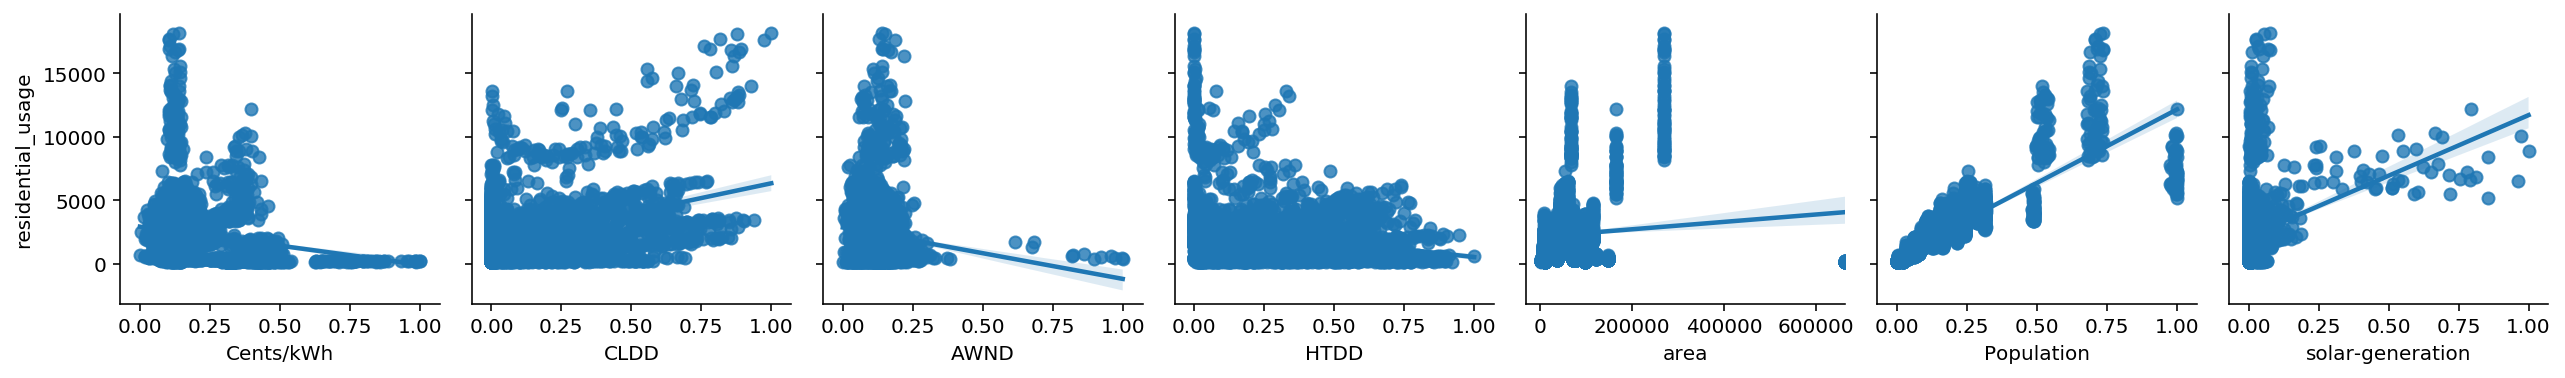

In [19]:
#concat for visualization
res = pd.concat([X_train, y_train], axis=1)

# Correlation Analysis
x_vars_list = ['Cents/kWh', 'CLDD', 'AWND', 'HTDD', 'area', 'Population', 'solar-generation']
y_vars_list = 'residential_usage'
correlation_analysis(res,x_vars_list, y_vars_list)

# Linar Regression

In [20]:
#Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
evaluate_performances(y_test, predictions)
df_pred_sklearn = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})

Mean Absolute Error: 336.1508399706748
Mean Squared Error: 266323.38946713373
Root Mean Squared Error: 516.0652957399226


In [21]:
#Linear Regression coefficients
a  = lr.intercept_#Intercept
b = lr.coef_#Coefficient
print("Intercept",a,",Coefficient：",b)

Intercept -752825481.4035958 ,Coefficient： [-6.57269698e+02  2.59632584e+03 -1.97077010e+01  1.22192304e+03
  1.63462426e+04 -1.01172300e+10 -1.04043936e+08 -1.16435039e+08
 -1.11048245e+09 -1.92295986e+09 -9.48720666e+08  6.62201715e+08
  7.12139226e+08 -3.22067135e+08 -2.18548712e+08  5.74225741e+08
 -1.67026819e+08 -6.13197563e+08 -1.93883586e+08  1.57544826e+08
 -5.92110952e+08  9.22578691e+07 -9.69825541e+07  5.80306784e+08
  5.50034090e+08  1.74429681e+08 -8.28068850e+08 -6.68235268e+08
 -3.86539679e+08 -3.88558772e+07 -1.65071000e+09 -1.26911367e+08
 -4.02821550e+08 -5.11540280e+08  6.00020495e+08  6.10236786e+08
 -1.23471463e+09 -1.05461148e+09 -1.38944988e+08  2.01059754e+07
 -3.89760407e+08 -8.55301399e+08  7.27570218e+08  2.29402949e+08
 -5.07731765e+08  6.39305752e+07 -3.63772230e+09 -6.34922028e+08
  5.36160356e+07  5.95639647e+08 -4.12628299e+08 -3.17788161e+08
  3.56756016e+08 -8.46033639e+08  1.00610868e+04  7.85431184e+02
  1.04937049e+02  2.64987394e+02  3.19594242e+0

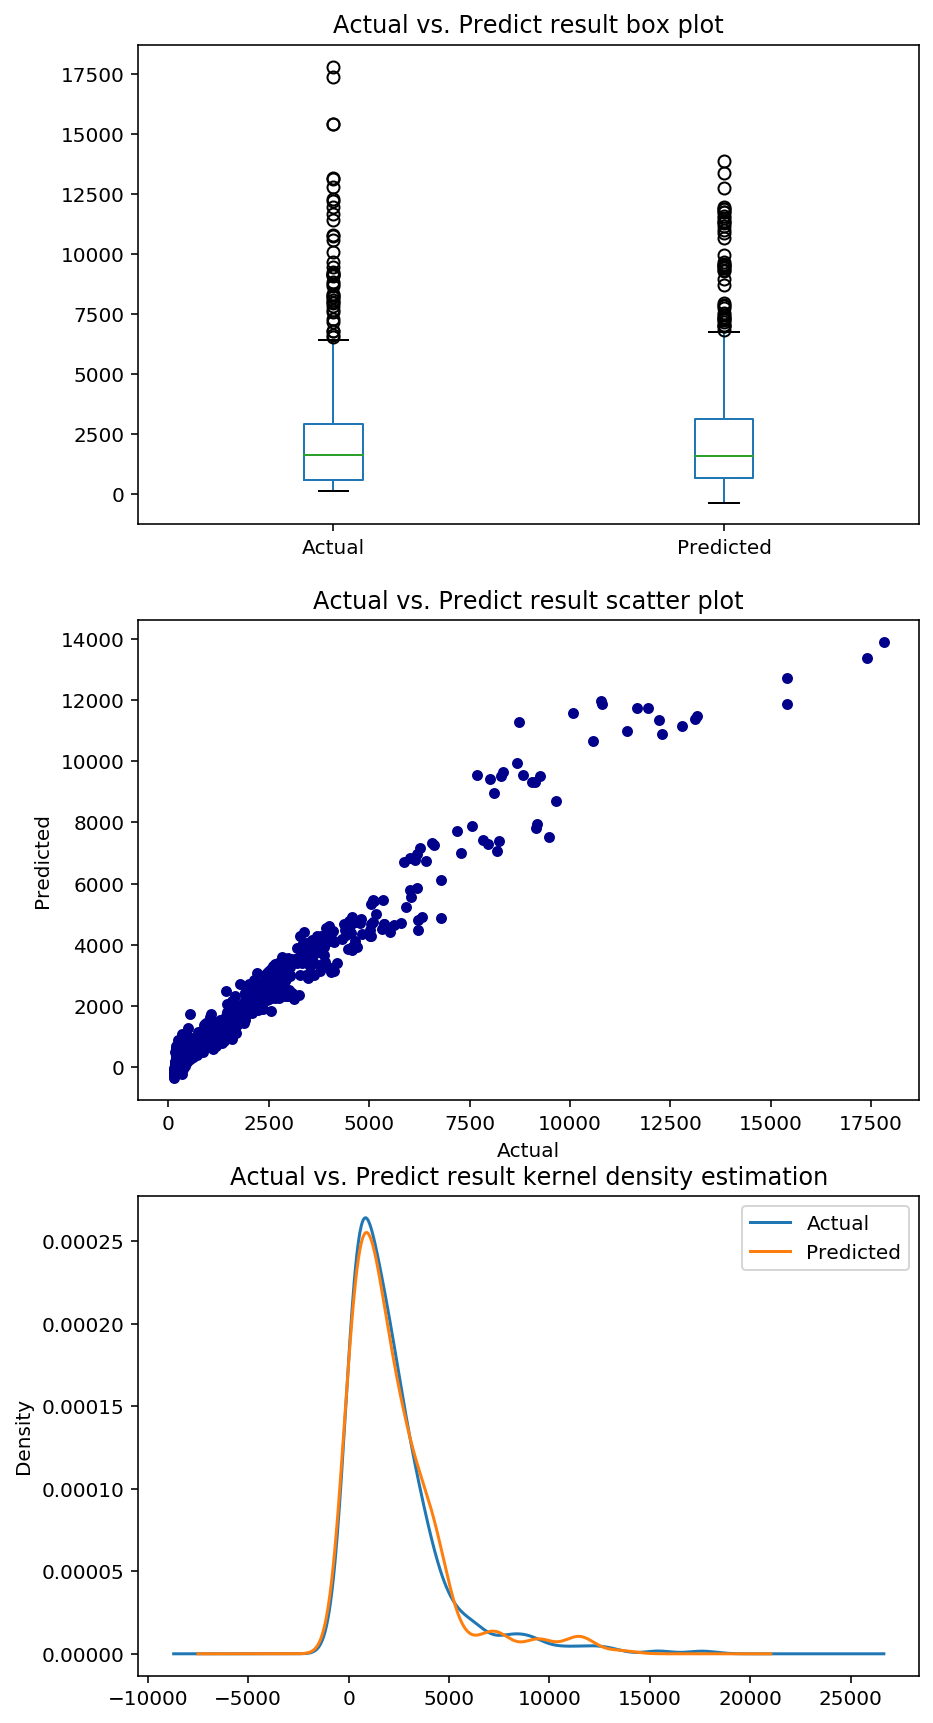

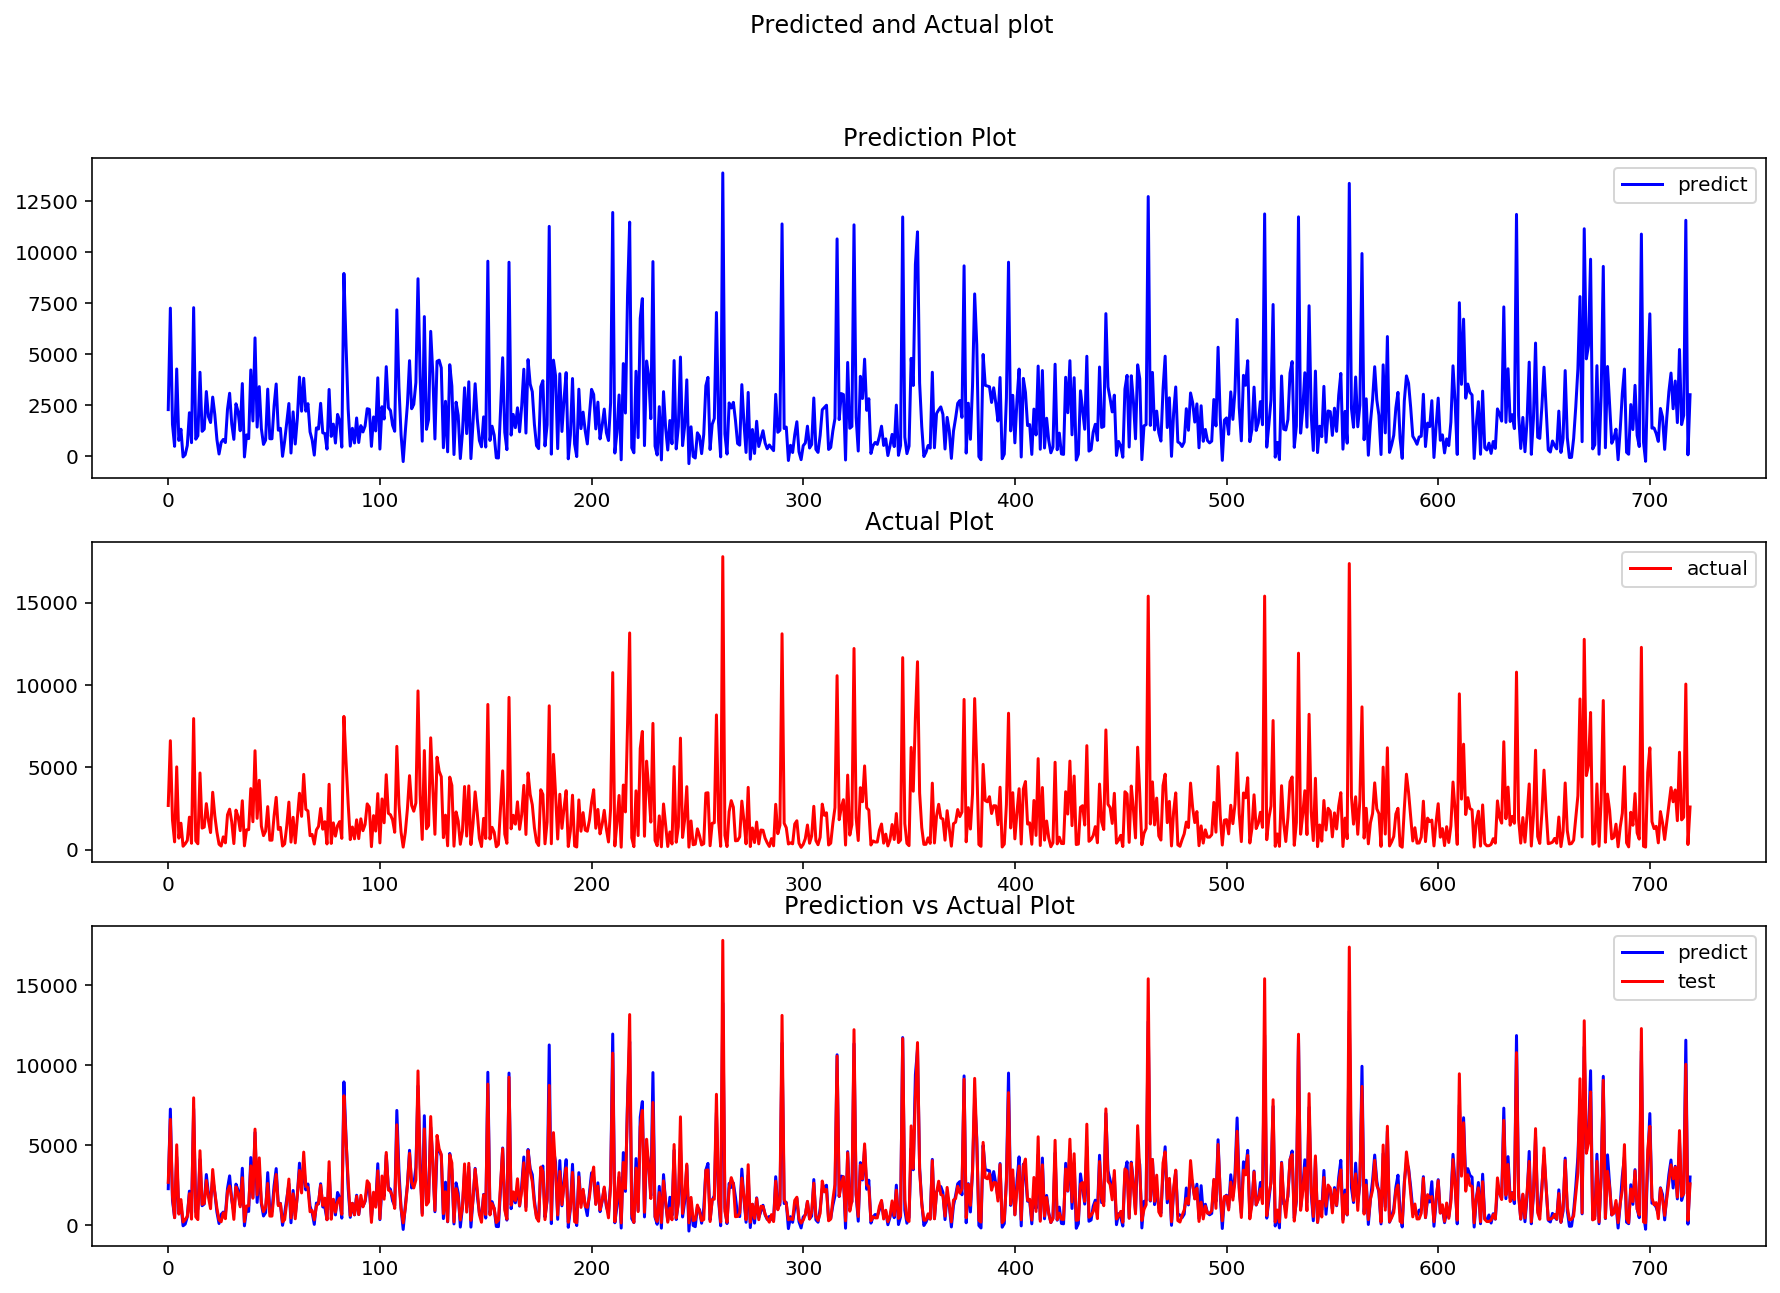

In [22]:
# Visualization
visualize_graph(df_pred_sklearn)
visualization(predictions,y_test)

                            OLS Regression Results                            
Dep. Variable:      residential_usage   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     1038.
Date:                Tue, 21 Jul 2020   Prob (F-statistic):               0.00
Time:                        08:26:17   Log-Likelihood:                -22146.
No. Observations:                2880   AIC:                         4.441e+04
Df Residuals:                    2821   BIC:                         4.476e+04
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              790.1119    863.032  

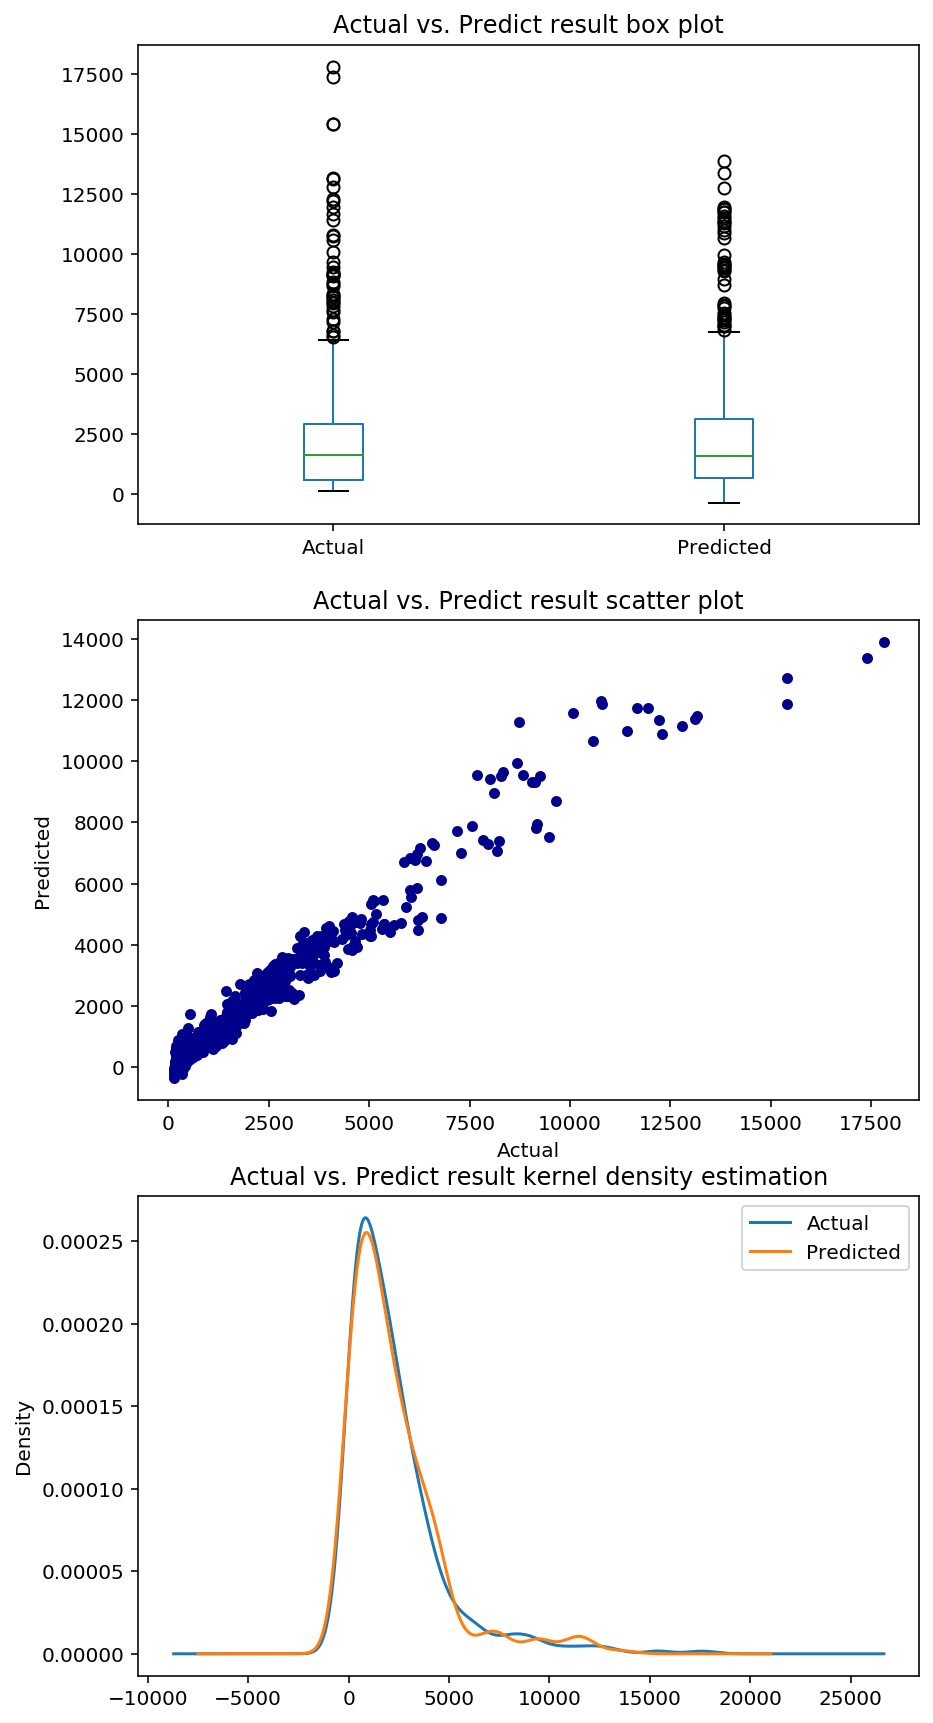

In [23]:
df_pred_sm = sm_regression(X_train,y_train,X_test,y_test)
visualize_graph(df_pred_sm)

# Feature Importances

Average RMSE with 5-fold Cross Validation: 304.176


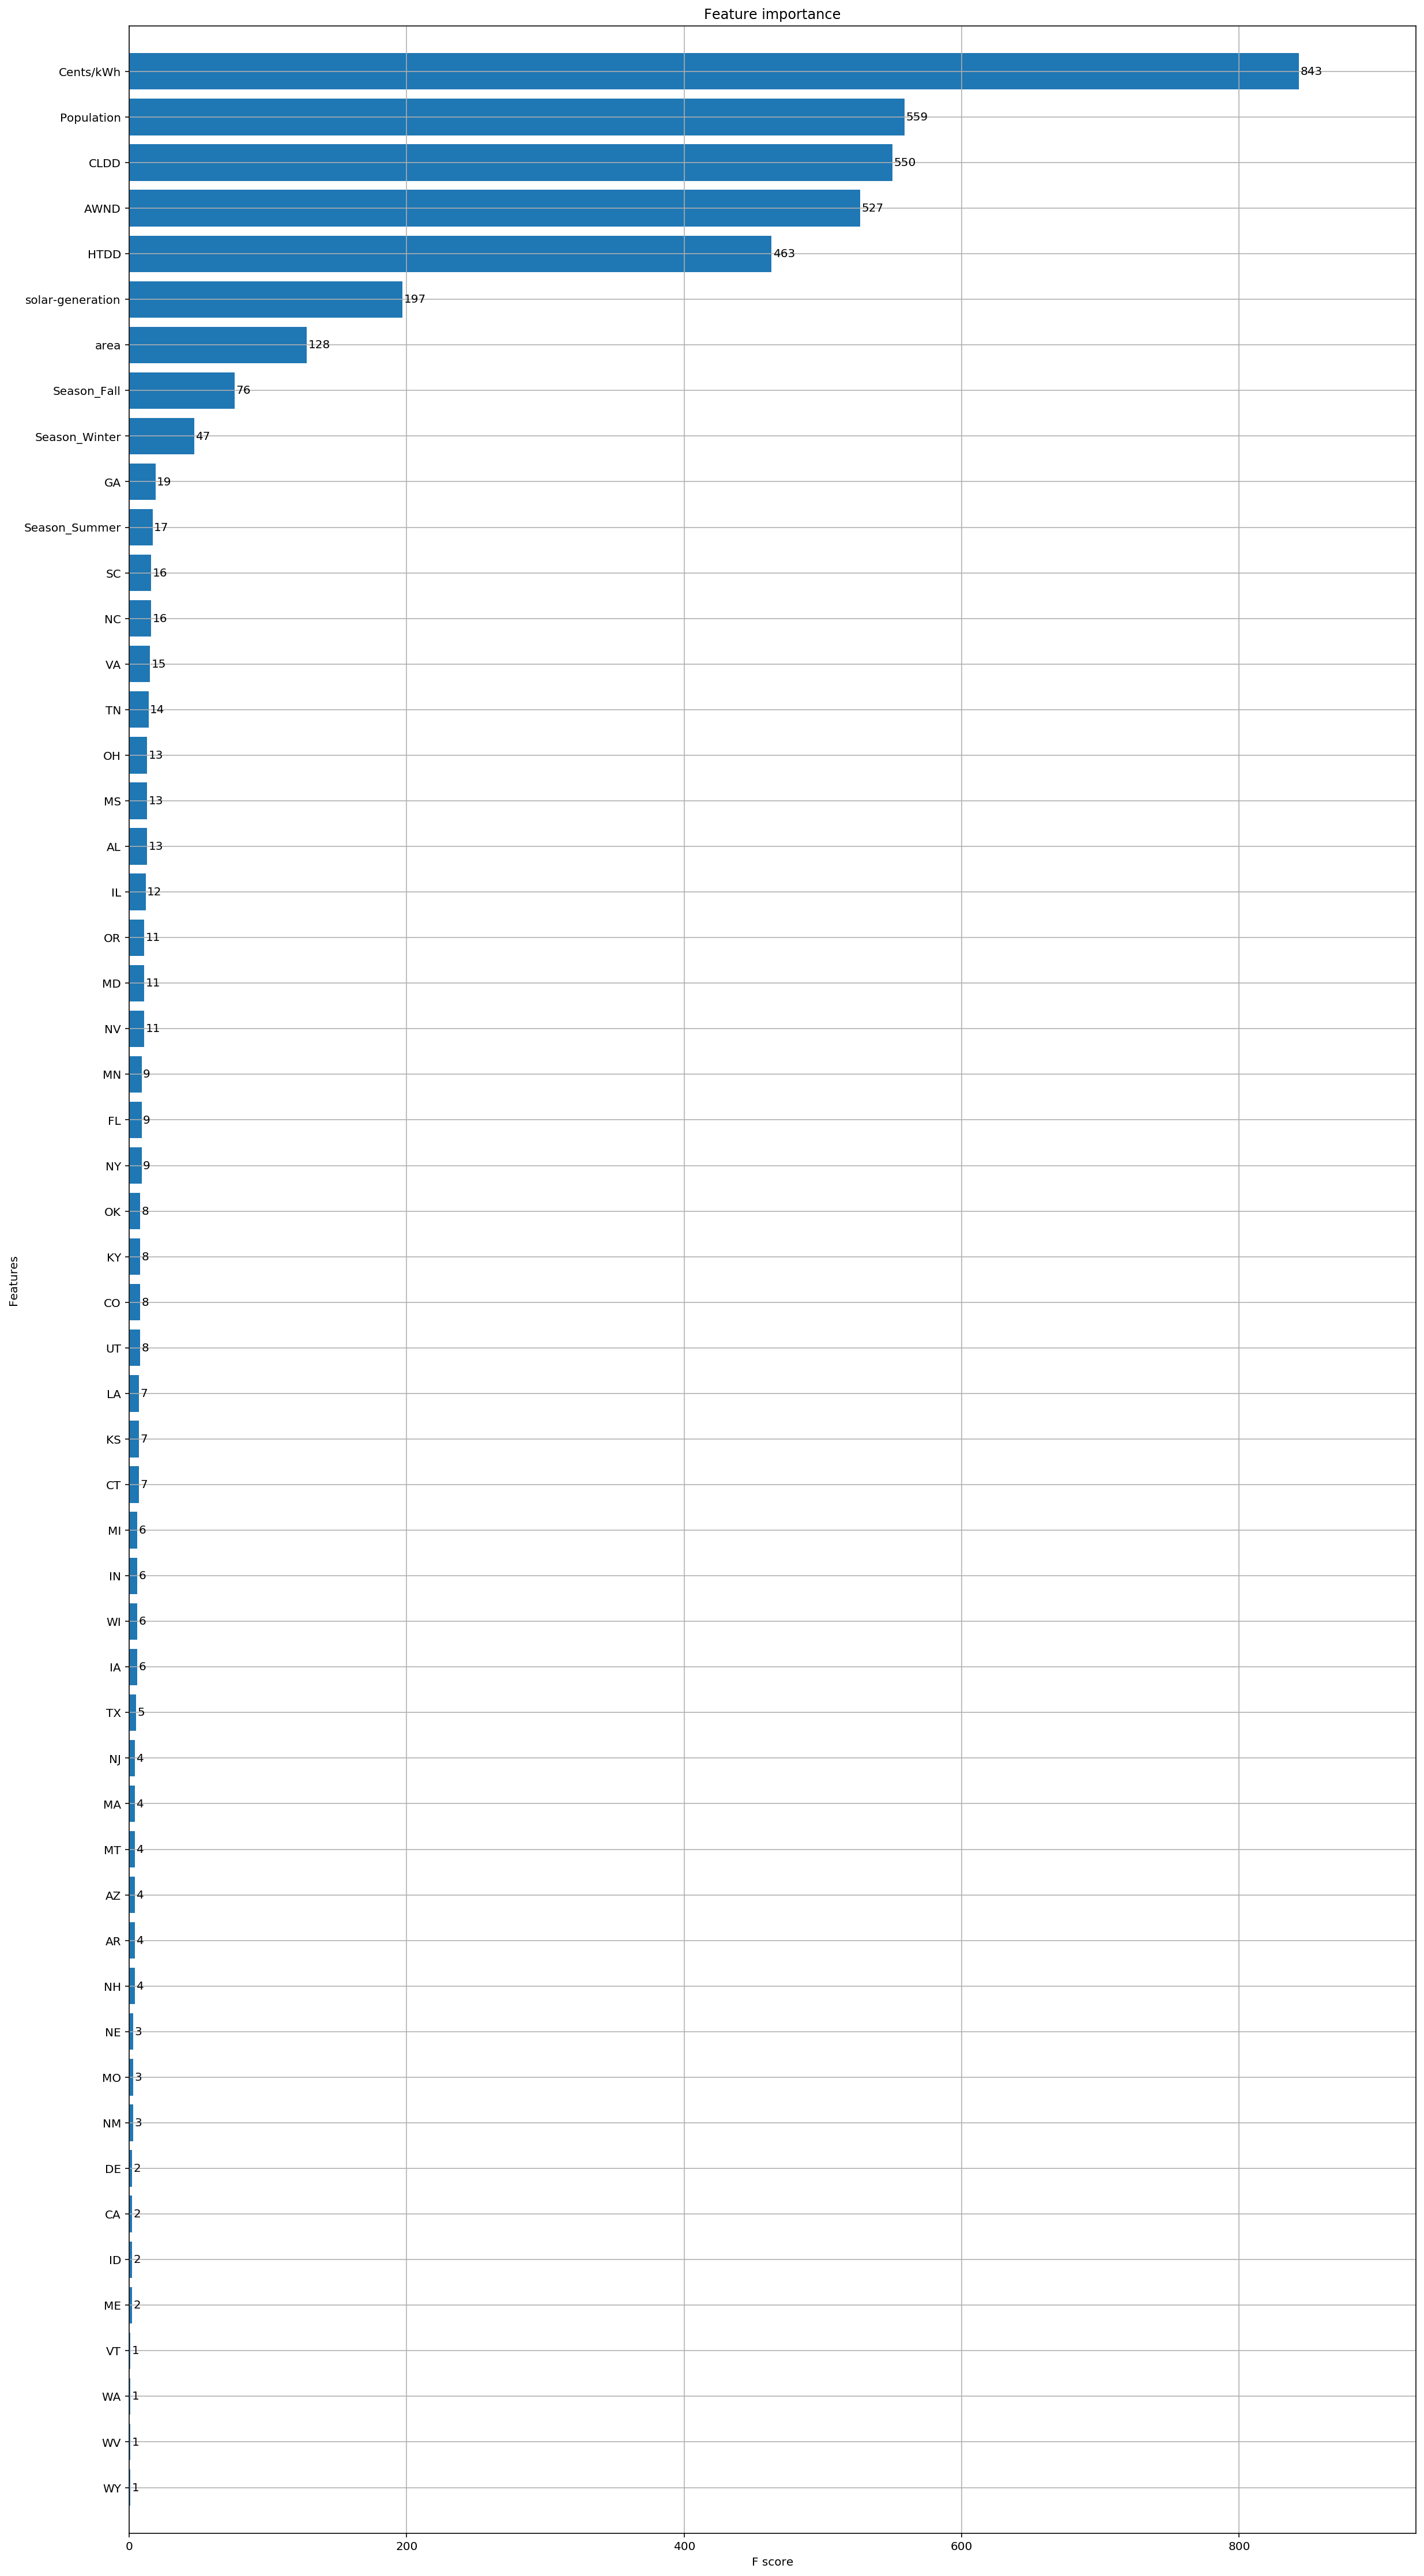

In [24]:
XGB(X_train, y_train)